# Finding the Best Multinomial Naive Bayes Classifier for Topic Classification

The provided notebook aims to find the best Multinomial Naive Bayes (MNB) classifier for topic classification using GridSearchCV.

# Training using the original dataset

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle

df = pd.read_pickle("out/df_final.pkl")

df

X = df.drop(columns=['topic_label'])

y = df['topic_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

pipeline = Pipeline([
    ('clf', MultinomialNB())
])

pipeline.fit(X_train, y_train)


# predict the labels for the test data
y_pred_default = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_default)
class_report = classification_report(y_test, y_pred_default)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

params = pipeline.get_params()

params, pipeline.score(X_test, y_test)

with open("out/mnb_original_dataset.pkl", "wb") as f:
    pickle.dump(pipeline.named_steps['clf'], f)

Confusion Matrix:
 [[ 107    7    8]
 [   4 1064  170]
 [   0   60  346]]
Classification Report:
               precision    recall  f1-score   support

      Events       0.96      0.88      0.92       122
   Lifestyle       0.94      0.86      0.90      1238
    Politics       0.66      0.85      0.74       406

    accuracy                           0.86      1766
   macro avg       0.86      0.86      0.85      1766
weighted avg       0.88      0.86      0.86      1766



# Training using the stratified dataset

In [26]:
import pickle

with open("supervised_train_test_data/train_test_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

pipeline = Pipeline([
    ('clf', MultinomialNB())
])

pipeline.fit(X_train, y_train)

y_pred_default = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_default)
class_report = classification_report(y_test, y_pred_default)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

params = pipeline.get_params()

params, pipeline.score(X_test, y_test)

with open("out/mnb_stratified_dataset.pkl", "wb") as f:
    pickle.dump(pipeline.named_steps['clf'], f)

Confusion Matrix:
 [[ 77   7   5]
 [  6 830 131]
 [  0  52 305]]
Classification Report:
               precision    recall  f1-score   support

      Events       0.93      0.87      0.90        89
   Lifestyle       0.93      0.86      0.89       967
    Politics       0.69      0.85      0.76       357

    accuracy                           0.86      1413
   macro avg       0.85      0.86      0.85      1413
weighted avg       0.87      0.86      0.86      1413



# Results

The first model, trained on the original dataset using a regular train-test split, achieved an accuracy score of approximately `85.90%`. This suggests that the model generalized reasonably well to unseen data and effectively learned patterns from the training data.

The second model, trained on a stratified dataset with a train-test split that maintains the same distribution of class labels as the original dataset, achieved a slightly lower accuracy score of around `85.77%`. Despite the minor decrease in accuracy compared to the first model, the difference is not substantial, indicating that the model trained on the stratified dataset still performs well.

# Summary

Both models demonstrate strong performance, with the model trained on the original dataset slightly outperforming the one trained on the stratified dataset. The difference in accuracy between the two models is minimal, suggesting that either approach could be viable depending on the specific requirements and characteristics of the dataset.

We will be using the stratified dataset to represent each topic proportionally.

## Hyperparameter Tuning

Hyperparameters for the MNB classifier are defined in the `parameters` dictionary. The notebook specifies a range of values for two hyperparameters: alpha (from 0.1 to 1.0 with a step size of 0.1) and fit_prior (True or False).

GridSearchCV is then employed to perform an exhaustive search over the specified hyperparameter values. The goal is to find the combination of hyperparameters that yields the best performance on the training data.

The scoring metric used for evaluation is the weighted F1-score (`f1_weighted`). This metric considers both precision and recall and is suitable for imbalanced classification problems.

In [28]:
import numpy as np

parameters = {
    'clf__alpha': np.arange(0.1, 1.1, 0.1),
    'clf__fit_prior': [True, False],
}

In [29]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters found:")
print(grid_search.best_params_)
print("Best cross-validation score:")
print(grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score:")
print(test_score)

print(best_model.get_params())


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:
{'clf__alpha': 0.1, 'clf__fit_prior': True}
Best cross-validation score:
0.8727260431365889
Test set score:
0.8690728945506015
{'memory': None, 'steps': [('clf', MultinomialNB(alpha=0.1))], 'verbose': False, 'clf': MultinomialNB(alpha=0.1), 'clf__alpha': 0.1, 'clf__class_prior': None, 'clf__fit_prior': True, 'clf__force_alpha': True}


## Best Parameters

After evaluating all candidate parameter combinations, the grid search identified the best hyperparameters for the model.
The best parameters found are:
1. `alpha: 0.1`
2. `fit_prior: True`

These values indicate that the optimal alpha value for Laplace smoothing is `0.1`, and the model is trained with prior probabilities estimated from the training data.

## Best Cross-Validation Score

The best cross-validation score achieved during the grid search is `0.8727`.

This score represents the weighted F1-score, which is a measure of the model's performance on the training data averaged across all folds.

A higher F1-score indicates better performance, with `1.0` being the best possible score.

## Test Set Score

After finding the best hyperparameters, the model is evaluated on the held-out test set to assess its performance on unseen data.

The test set score obtained is `0.8691`, which indicates the accuracy of the model on the test data.

A high test set score suggests that the model generalizes well to new, unseen data, providing confidence in its predictive performance.

Confusion Matrix:
[[ 76   9   4]
 [  3 846 118]
 [  0  51 306]]
[[0.85393258 0.00930714 0.01120448]
 [0.03370787 0.87487073 0.33053221]
 [0.         0.05274043 0.85714286]]
['Events' 'Lifestyle' 'Politics'] ['Events' 'Lifestyle' 'Politics']


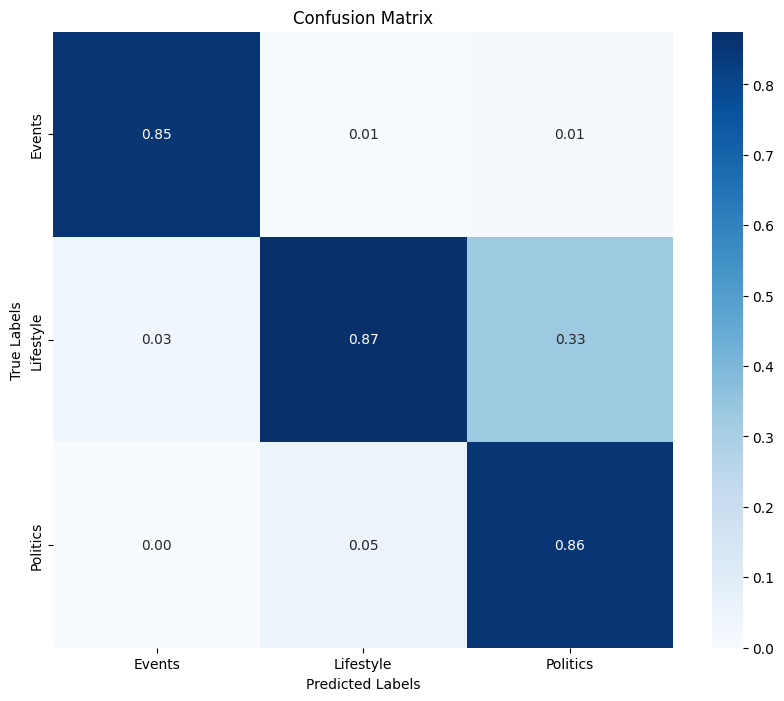

In [30]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_totals = y_test.value_counts()

y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

conf_matrix = conf_matrix / conf_matrix.astype(float).sum(axis=1)

print(conf_matrix)

print(best_model.classes_, best_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Insights

1. The model performs quite well in predicting the `Events` class, with approximately 85.39% of the samples correctly classified.
2. The model shows relatively good performance in predicting the `Lifestyle` class, with approximately 87.49% of the samples correctly classified.
3. The model performs well in predicting the `Politics` class, with approximately 85.71% of the samples correctly classified.
4. There is a considerable rate of misclassification, with 33.05% `Lifestyle` samples being incorrectly classified as `Politics`

In [31]:
best_model = grid_search.best_estimator_

with open("out/best_mnb.pkl", "wb") as f:
    pickle.dump(best_model, f)